In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder
from itertools import product

%matplotlib inline

In [2]:
train = pd.read_csv('../data/sales_history.csv')
item_cat = pd.read_csv('../data/item_categories.csv')
cat_name = pd.read_csv('../data/category_names.csv')
test = pd.read_csv('../data/test.csv', index_col=0)

submit = pd.read_csv('../data/sample_submission.csv')

train.columns = 'date shop_id item_id price item_cnt_day'.split()
test.columns = 'item_id shop_id'.split()
cat_name.columns = 'cat_id cat_name'.split()
item_cat.columns = 'item_id cat_id'.split()


In [3]:
train.head()

,date,shop_id,item_id,price,item_cnt_day
0,2018-01-01,9,1000001,420,1.0
1,2018-01-01,6,1000001,420,1.0
2,2018-01-01,10,1000001,420,1.0
3,2018-01-01,0,1000017,250,1.0
4,2018-01-01,1,1000017,250,1.0


In [19]:
test

,item_id,shop_id
index,,
0,1000001,0
1,1000001,1
2,1000001,2
3,1000001,3
4,1000001,4
...,...,...
3055,3500001,13
3056,3500001,14
3057,3500001,15


In [18]:
submit

,0,100
0,1,100
1,2,100
2,3,100
3,4,100
4,5,100
...,...,...
3054,3055,100
3055,3056,100
3056,3057,100
3057,3058,100


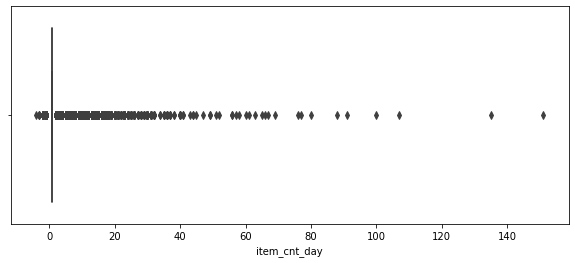

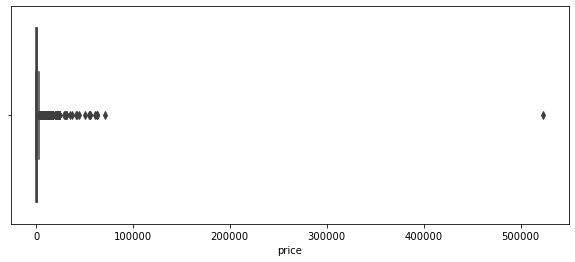

In [6]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
sns.boxplot(x=train.price)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119570 entries, 0 to 1119569
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   date          1119570 non-null  object 
 1   shop_id       1119570 non-null  int64  
 2   item_id       1119570 non-null  int64  
 3   price         1119570 non-null  int64  
 4   item_cnt_day  1119570 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 42.7+ MB


In [8]:
train[train.item_cnt_day> 120]

,date,shop_id,item_id,price,item_cnt_day
516829,2018-10-06,9,1100302,1020,135.0
946871,2019-06-20,9,1100336,130,151.0


In [9]:
train = train[train.price <200000]
train = train[train.item_cnt_day < 120]
train.price.max()

71400

In [10]:
train.loc[train.item_cnt_day < 0 ,'item_cnt_day'] = 0

In [11]:
train[train.item_id<0]

,date,shop_id,item_id,price,item_cnt_day


In [12]:
cat_name.columns

Index(['cat_id', 'cat_name'], dtype='object')

In [13]:
item_cat

,item_id,cat_id
0,1000001,100
1,1000002,100
2,1000003,100
3,1000004,100
4,1000005,100
...,...,...
9421,3500072,350
9422,3500073,350
9423,3500074,350
9424,3500075,350


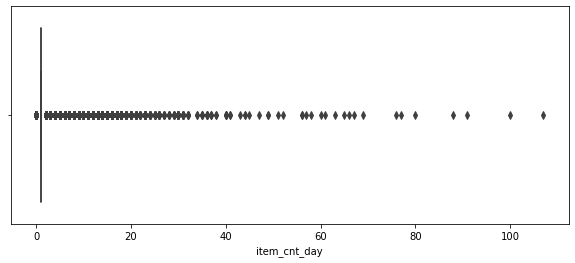

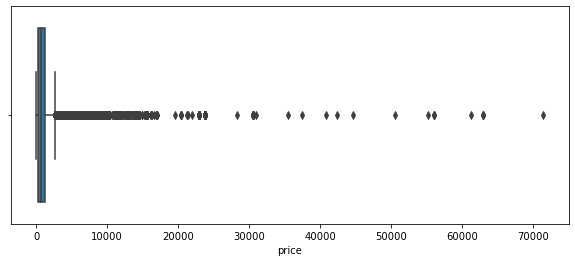

In [14]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
sns.boxplot(x=train.price)

In [15]:
def add_monthly_idx(x):
    if x >= '2018-01-01' and x < '2018-02-01':
        return 0
    elif x >= '2018-02-01' and x < '2018-03-01':
        return 1
    elif x >= '2018-03-01' and x < '2018-04-01':
        return 2
    elif x >= '2018-04-01' and x < '2018-05-01':
        return 3
    elif x >= '2018-05-01' and x < '2018-06-01':
        return 4
    elif x >= '2018-06-01' and x < '2018-07-01':
        return 5
    elif x >= '2018-07-01' and x < '2018-08-01':
        return 6
    elif x >= '2018-08-01' and x < '2018-09-01':
        return 7
    elif x >= '2018-09-01' and x < '2018-10-01':
        return 8
    elif x >= '2018-10-01' and x < '2018-11-01':
        return 9
    elif x >= '2018-11-01' and x < '2018-12-01':
        return 10
    elif x >= '2018-12-01' and x < '2019-01-01':
        return 11
    elif x >= '2019-01-01' and x < '2019-02-01':
        return 12
    elif x >= '2019-02-01' and x < '2019-03-01':
        return 13
    elif x >= '2019-03-01' and x < '2019-04-01':
        return 14
    elif x >= '2019-04-01' and x < '2019-05-01':
        return 15
    elif x >= '2019-05-01' and x < '2019-06-01':
        return 16
    elif x >= '2019-06-01' and x < '2019-07-01':
        return 17
    elif x >= '2019-07-01' and x < '2019-08-01':
        return 18
    elif x >= '2019-08-01' and x < '2019-09-01':
        return 19
    elif x >= '2019-09-01' and x < '2019-10-01':
        return 20
    elif x >= '2019-10-01' and x < '2019-11-01':
        return 21
    else:
        return 22 


In [16]:
train['month_idx'] = train['date'].apply(add_monthly_idx)

In [17]:
cat_name['sprit'] = cat_name['cat_name'].str.split('-')
cat_name['type'] = cat_name['sprit'].map(lambda x: x[0].strip())
cat_name['type_code'] = LabelEncoder().fit_transform(cat_name['type'])
cat_name = cat_name[['cat_id','type_code']]

In [17]:
train['month_idx'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [18]:
train['month_idx'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [19]:
train['shop_id'].unique()

array([ 9,  6, 10,  0,  1, 13,  8,  2, 15, 14,  5,  7, 16, 11, 12,  3,  4,
       17])

In [20]:
matrix = []
cols = ['month_idx','shop_id', 'item_id']

for i in range(22):
    sales = train[train.month_idx==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int64'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)    
matrix['month_idx'] = matrix['month_idx'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int64)

matrix.sort_values(cols, inplace=True)

In [21]:
matrix.head()

,month_idx,shop_id,item_id
13860,0,0,1000001
14478,0,0,1000002
16299,0,0,1000003
14479,0,0,1000004
14480,0,0,1000005


In [22]:
train['revenue'] = train['price'] * train['item_cnt_day']


In [23]:
group = train.groupby(['month_idx', 'shop_id', 'item_id']).agg({'item_cnt_day':['sum']})
group.columns= ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))
                                


In [24]:
matrix

,month_idx,shop_id,item_id,item_cnt_month
0,0,0,1000001,6.0
1,0,0,1000002,2.0
2,0,0,1000003,0.0
3,0,0,1000004,1.0
4,0,0,1000005,8.0
...,...,...,...,...
1648903,21,17,3500063,0.0
1648904,21,17,3500070,0.0
1648905,21,17,3500071,0.0
1648906,21,17,3500072,0.0


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3060 entries, 0 to 3059
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   item_id  3060 non-null   int64
 1   shop_id  3060 non-null   int64
dtypes: int64(2)
memory usage: 71.7 KB


In [26]:
test['month_idx'] = 22
test['month_idx'] = test['month_idx'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int64)


In [27]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0,inplace=True)


In [28]:
matrix = pd.merge(matrix, item_cat, on=['item_id'], how='left')
matrix = pd.merge(matrix, cat_name, on=['cat_id'], how='left')


In [29]:
matrix

,month_idx,shop_id,item_id,item_cnt_month,cat_id,type_code
0,0,0,1000001,6.0,100,5
1,0,0,1000002,2.0,100,5
2,0,0,1000003,0.0,100,5
3,0,0,1000004,1.0,100,5
4,0,0,1000005,8.0,100,5
...,...,...,...,...,...,...
1651963,22,13,3500001,0.0,350,6
1651964,22,14,3500001,0.0,350,6
1651965,22,15,3500001,0.0,350,6
1651966,22,16,3500001,0.0,350,6


In [30]:
group = matrix.groupby(['month_idx']).agg({'item_cnt_month':['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)


In [31]:
group

,month_idx,date_avg_item_cnt
0,0,0.779785
1,1,0.743164
2,2,0.798828
3,3,0.637695
4,4,0.613281
5,5,0.697266
6,6,0.689453
7,7,0.761230
8,8,0.693848
9,9,0.688965


In [32]:
def lag_feature(df, lags, col):
    tmp = df[['month_idx', 'shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['month_idx','shop_id', 'item_id', col+'_lag_'+str(i)]
        shifted['month_idx'] += i
        df = pd.merge(df, shifted, on=['month_idx','shop_id','item_id'], how='left')
    return df

matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')    


In [33]:
matrix

,month_idx,shop_id,item_id,item_cnt_month,cat_id,type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,1000001,6.0,100,5,NaN,NaN,NaN,NaN,NaN
1,0,0,1000002,2.0,100,5,NaN,NaN,NaN,NaN,NaN
2,0,0,1000003,0.0,100,5,NaN,NaN,NaN,NaN,NaN
3,0,0,1000004,1.0,100,5,NaN,NaN,NaN,NaN,NaN
4,0,0,1000005,8.0,100,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1651963,22,13,3500001,0.0,350,6,2.0,3.0,1.0,2.0,1.0
1651964,22,14,3500001,0.0,350,6,0.0,0.0,0.0,0.0,0.0
1651965,22,15,3500001,0.0,350,6,0.0,0.0,0.0,1.0,0.0
1651966,22,16,3500001,0.0,350,6,0.0,0.0,0.0,0.0,0.0


In [34]:
group = train.groupby(['item_id']).agg({'price':['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)


group = train.groupby(['month_idx','item_id']).agg({'price':['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['month_idx','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix= lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price'])/matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0


matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price','date_item_avg_item_price']

for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

 

In [35]:
group = train.groupby(['month_idx','shop_id']).agg({'revenue':['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['month_idx','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)


group = group.groupby(['shop_id']).agg({'date_shop_revenue':['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue']-matrix['shop_avg_revenue'])/matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'delta_revenue')
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)


In [36]:
matrix

,month_idx,shop_id,item_id,item_cnt_month,cat_id,type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,delta_price_lag,delta_revenue_lag_1
0,0,0,1000001,6.0,100,5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,0,0,1000002,2.0,100,5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,0,0,1000003,0.0,100,5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
3,0,0,1000004,1.0,100,5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
4,0,0,1000005,8.0,100,5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651963,22,13,3500001,0.0,350,6,2.0,3.0,1.0,2.0,1.0,-0.028259,-0.122681
1651964,22,14,3500001,0.0,350,6,0.0,0.0,0.0,0.0,0.0,-0.028259,-0.463623
1651965,22,15,3500001,0.0,350,6,0.0,0.0,0.0,1.0,0.0,-0.028259,-0.067139
1651966,22,16,3500001,0.0,350,6,0.0,0.0,0.0,0.0,0.0,-0.028259,-0.099121


In [37]:
matrix['month'] = matrix['month_idx'] % 12 

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)


In [38]:
matrix

,month_idx,shop_id,item_id,item_cnt_month,cat_id,type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,delta_price_lag,delta_revenue_lag_1,month,days
0,0,0,1000001,6.0,100,5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,31
1,0,0,1000002,2.0,100,5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,31
2,0,0,1000003,0.0,100,5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,31
3,0,0,1000004,1.0,100,5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,31
4,0,0,1000005,8.0,100,5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651963,22,13,3500001,0.0,350,6,2.0,3.0,1.0,2.0,1.0,-0.028259,-0.122681,10,30
1651964,22,14,3500001,0.0,350,6,0.0,0.0,0.0,0.0,0.0,-0.028259,-0.463623,10,30
1651965,22,15,3500001,0.0,350,6,0.0,0.0,0.0,1.0,0.0,-0.028259,-0.067139,10,30
1651966,22,16,3500001,0.0,350,6,0.0,0.0,0.0,0.0,0.0,-0.028259,-0.099121,10,30


In [39]:
matrix.columns

Index(['month_idx', 'shop_id', 'item_id', 'item_cnt_month', 'cat_id',
       'type_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'delta_price_lag', 'delta_revenue_lag_1', 'month', 'days'],
      dtype='object')

In [40]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month !=0:
            cache[key] = row.month_idx
    else:
        last_date_block_num = cache[key]
        if row.month_idx > last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.month_idx - last_date_block_num
            cache[key] = row.month_idx


In [41]:
matrix['item_shop_first_sale'] = matrix['month_idx'] - matrix.groupby(['item_id','shop_id'])['month_idx'].transform('min')
matrix['item_first_sale'] = matrix['month_idx'] - matrix.groupby('item_id')['month_idx'].transform('min')


In [42]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df


matrix = fill_na(matrix)


In [43]:
import pickle

In [44]:
matrix.to_pickle('data.pkl')
